# PROJET 5 : Catégorisez automatiquement les questions 

**PLAN DE PROJET**
1. Titre de projet : PROJET 5 - Catégorisez automatiquement les questions


2. Chargement de bibliothèques


3. Récupérer les données + Séparation de données en test et train
    - Enregistrement de fichiers en .csv :
        - X_train.csv
        - y_train.csv
        - X_test.csv
        - y_test.csv


4. Data cleaning
    - Features :
        - Enlever les balises HTML
        - Enlever la ponctuation
        - Mise en minuscule et tokenization
        - Enlever les stopwords
    - Target :
        - Enlever les balises "<>"


5. Feature engineering 
    - Recodage en bigrams
    - Fusion de title, body + bigrams


6. Analyse exploratoire
    - Analyses univariées
        - Description générale : Longueur de posts, nombre de tags
        - Bag of words : Les expressions les plus fréquentes : feature & target
            - Arrays générées:
                - X_train_bow
                - X_train_vocab_bow
                - X_train_dist_bow
                - y_train_bow
                - y_train_vocab_bow
                - y_train_dist_bow
                
                
        - TF - IDF : Les expressions les plus fréquentes : feature & target
             - Arrays générées:
                  - X_train_ifidf
                  - X_train_vocab_ifidf
                  - X_train_dist_ifidf
                  - y_train_ifidf
                  - y_train_vocab_ifidf
                  - y_train_dist_ifidf
                  

    - Analyse multivarié 
    **QUESTION : Peut-on considérer LDA comme analyse multivariée ?**
    
    
    - Réduction de dimensions
    **QUESTION : Peut-on faire un word2vec ?**
    
    
        

# Chargement de bibliothéques

In [1]:
# Import the libraries
import joblib
from IPython.core.display import display, HTML
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

import nltk
#nltk.download()  # Download text data sets, including stop words
from nltk.corpus import stopwords # Import the stop word list
import re

# Import BeautifulSoup into your workspace
from bs4 import BeautifulSoup 
from gensim import corpora
from gensim import models
import numpy as np
import pyLDAvis
import pyLDAvis.gensim

# Libraries for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
#Disable warning for .loc
pd.options.mode.chained_assignment = None  # default='warn'

# Récupération de données

## Loader les fichiers .csv

In [3]:
# Load the .csv files
X_train = pd.read_csv('Data/X_train.csv', sep='\t')
X_test = pd.read_csv('Data/X_test.csv', sep='\t')
y_train = pd.read_csv('Data/y_train.csv', sep='\t')
y_test = pd.read_csv('Data/y_test.csv', sep='\t')

In [4]:
# Check the loaded files
print ("Le jeu de données X_train contient", X_train.shape[0], "observations et", X_train.shape[1], "features.") 
print ("Le vecteur y_train contient", y_train.shape[0], "observations.") 
print ("Le jeu de données X_test contient", X_test.shape[0], "observations et", X_test.shape[1], "features.") 
print ("Le vecteur y_test contient", y_test.shape[0], "observations.")  

Le jeu de données X_train contient 9843 observations et 3 features.
Le vecteur y_train contient 9842 observations.
Le jeu de données X_test contient 9844 observations et 3 features.
Le vecteur y_test contient 9843 observations.


## Récupérer les arrays

### Bag of words

In [5]:
# Load the arrays 
X_train_bow = np.load('Data/X_train_bow.npy')
X_train_vocab_bow = np.load('Data/X_train_vocab_bow.npy')
X_train_dist_bow = np.load('Data/X_train_dist_bow.npy')
y_train_bow = np.load('Data/y_train_bow.npy')
y_train_vocab_bow = np.load('Data/y_train_vocab_bow.npy')
y_train_dist_bow = np.load('Data/y_train_dist_bow.npy')
X_train_title_bow = np.load('Data/X_train_title_bow.npy')
X_train_title_vocab_bow = np.load('Data/X_train_title_vocab_bow.npy')
X_train_title_dist_bow = np.load('Data/X_train_title_dist_bow.npy')

In [112]:
# test !!!

y_train_bow100 = np.load('Data/y_train_bow100.npy')
y_train_vocab_bow100 = np.load('Data/y_train_vocab_bow100.npy')
y_train_dist_bow100 = np.load('Data/y_train_dist_bow100.npy')

### TF-IDF

In [6]:
# Load the arrays 
X_train_tfidf = np.load('Data/X_train_tfidf.npy')
X_train_vocab_tfidf = np.load('Data/X_train_vocab_tfidf.npy')
X_train_dist_tfidf = np.load('Data/X_train_dist_tfidf.npy')
y_train_tfidf = np.load('Data/y_train_tfidf.npy')
y_train_vocab_tfidf = np.load('Data/y_train_vocab_tfidf.npy')
y_train_dist_tfidf = np.load('Data/y_train_dist_tfidf.npy')
X_train_title_tfidf = np.load('Data/X_train_title_tfidf.npy')
X_train_title_vocab_tfidf = np.load('Data/X_train_title_vocab_tfidf.npy')
X_train_title_dist_tfidf = np.load('Data/X_train_title_dist_tfidf.npy')

### Word2vect

In [7]:
X_train_post_w2v = np.load('Data/X_train_post_w2v.npy')
X_train_title_w2v = np.load('Data/X_train_title_w2v.npy')

# Modélisation de flags basée sur les fréquences

## Fréquences BOW

Nous allons mettre en oeuvre une méthode basée uniquement sur les fréquences des expressions (mot / bigram) utilisées dans le post et nous allons regarder si les expressions les plus fréquentes apparaissent dans le vocabulaire de tags.

Tout d'abord, nous allons analyser s'il existe un ou plusieurs expressions, présentes au moins deux fois dans chaque post, qui matchent avec le vocabulaire de tags. 

Nous allons utiliser la décomposition en Bag of words créé dans le notebook1, chapître 6.1.2 :

In [7]:
#The tags vocabulary :
y_train_vocab_bow[:10]

array(['.a', '.d.ts', '.htaccess', '.net', '.net-2.0', '.net-3.5',
       '.net-4.0', '.net-4.5', '.net-assembly', '.net-attributes'],
      dtype='<U31')

In [8]:
#The features vocabulary : 
X_train_vocab_bow[:10]

array(['##', '##-##', '#-#', '#-b', '#-bin', '#-branch', '#-change',
       '#-error', '#-modified', '#-new'], dtype='<U33')

In [9]:
#The BOW array :
X_train_bow[:10]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Tester les fonctions sur le premier post

Nous allons tester notre idée sur le premier post.

In [10]:
BOW_post1 = X_train_bow[0]
BOW_post1

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [11]:
#We print all expressions which are at least 2 times in the post :
for freq, word in zip(BOW_post1, X_train_vocab_bow):
    if freq >= 2:
        print (freq, word)

2 constructor
5 error
3 message


In [12]:
#We compare the frequent expression to the tag's vocab:

for freq, word in zip(BOW_post1, X_train_vocab_bow):
    if freq >= 2:
        if word in y_train_vocab_bow:
            print(word)

constructor
message


In [13]:
predicted_tags_vect = []

for freq, word in zip(BOW_post1, X_train_vocab_bow):
    if freq >= 2:
        if word in y_train_vocab_bow:
            predicted_tags_vect.append(word)

predicted_tags_vect

['constructor', 'message']

### Création d'une fonction à appliquer sur toutes les données

Maintenant, nous allons créer une fonction qui va sortir les tags pour chaque post :

In [14]:
def pred_tag_freq(BOW, vocabulary, list_of_tags):
    
    """Function which generates a list of tags, based on frequency of expression in a BOW object and 
    its comparison to predefined list of tags.
    
    Input :
    - BOW : a BOW array
    - vocabulary : list of BOW vocabulary
    - list_of_tags : a list of tags
    
    Output :
    - a list of predicted tags  
    
    """
    predicted_tags = []
    
    for vect in range(BOW.shape[0]): 
        
        predicted_tags_vect = [] 
        
        for freq, word in zip(BOW[vect], vocabulary):
            
            if freq >= 2:
                if word in list_of_tags:
                    predicted_tags_vect.append(word)
                    
        predicted_tags.append(predicted_tags_vect)
        
    return predicted_tags

In [15]:
predicted_tags = pred_tag_freq(X_train_bow, X_train_vocab_bow, y_train_vocab_bow)

In [16]:
len(predicted_tags)

9843

In [17]:
predicted_tags[:10]

[['constructor', 'message'],
 ['latitude-longitude'],
 ['android', 'crash'],
 ['exception', 'window'],
 ['feed', 'r'],
 ['cgi', 'difference', 'uri'],
 ['dependency-injection', 'function', 'interface', 'object', 'virtual'],
 ['ascii',
  'break',
  'c',
  'c++',
  'case',
  'char',
  'const',
  'count',
  'function',
  'github',
  'int',
  'integer',
  'letter',
  'malloc',
  'max',
  'min',
  'null',
  'printf',
  'return',
  'size',
  'sizeof',
  'stack',
  'store',
  'unsigned',
  'void'],
 ['max', 'mysql', 'set', 'size', 'varchar'],
 ['c',
  'csv',
  'dataframe',
  'import',
  'letter',
  'np',
  'numpy',
  'row',
  'split',
  'string',
  'transform',
  'var']]

Sauvegarder les tags prédits:

In [18]:
#Save the predicted tags:
np.save('Data/predicted_tags', predicted_tags)

Nous allons analyser le nombre de tag prédits par la méthode :

In [19]:
nbr_tags = []

for tag in range(len(predicted_tags)):
    length = len(predicted_tags[tag])
    nbr_tags.append(length)
    
nbr_tags = DataFrame(nbr_tags)

In [20]:
nbr_tags[0].value_counts()

2     1783
3     1742
4     1280
1     1182
5      897
6      623
0      479
7      408
8      326
9      233
10     157
11     134
12      91
13      71
14      66
15      63
16      43
17      35
19      32
18      31
20      30
23      18
21      17
25      16
22      15
26       7
24       6
31       5
29       5
32       5
28       4
30       4
34       3
47       3
42       3
27       3
51       2
38       2
40       2
48       2
35       2
41       2
39       2
43       1
33       1
58       1
76       1
37       1
45       1
74       1
46       1
67       1
Name: 0, dtype: int64

Désavantage de la méthode : nous avons des posts sans tag attribué (479 posts) et certains posts peuvent avoir un grand nombre de tags, même si c'est plutôt rare. Nous allons appliquer la même méthode avec TF-IDF et choisir 3 tags les plus fréquents basé sur le coefficient TF-IDF. 

## Fréquences TF-IDF

L'idée est d'utiliser les fréquences TF-IDF pour avoir la main sur le nombre de tags à prédire. Cette fois-ci, la méthode sera basé sur la procédure suivante :

1. Nous allons comparer toutes les expressions dans le post avec le vocabulaire de tags
2. Nous allons attribuer à chaque expression la distance relative TF-IDF de tag
3. Nous allons sortir 3 tags les plus fréquents

In [21]:
y_train_dist_tfidf[:10]

array([  0.57676875,   0.81346388,   5.41406727, 113.99212282,
         1.90929443,   5.74109131,   3.80868117,   4.5396082 ,
         0.58506653,   1.6894902 ])

### Tester les fonctions sur le premier post

In [22]:
#Extract the array of first post
TFIDF_post1 = X_train_tfidf[0]
TFIDF_post1

array([0., 0., 0., ..., 0., 0., 0.])

In [23]:
#We compare the expressions in the post to the tag's vocab:
for freq, word in zip(TFIDF_post1, X_train_vocab_tfidf):
    if freq > 0:
        if word in y_train_vocab_tfidf:
            print(word)

apply
console
constructor
function
javascript
message
prototype
subclass
var


In [24]:
#We list the common expressions which are in both document and the tag's vocabulary:

liste_tags = []

for freq, word in zip(TFIDF_post1, X_train_vocab_tfidf):
    if freq > 0:
        if word in y_train_vocab_tfidf:
            liste_tags.append(word)

In [25]:
liste_tags

['apply',
 'console',
 'constructor',
 'function',
 'javascript',
 'message',
 'prototype',
 'subclass',
 'var']

In [26]:
#We zip the list with tag's relative frequency:

for freq, word in zip(y_train_dist_tfidf, liste_tags):
    print(freq, word)

0.5767687452625023 apply
0.813463876986981 console
5.414067269547913 constructor
113.99212281549468 function
1.9092944332315822 javascript
5.741091311565432 message
3.808681173132807 prototype
4.539608202141523 subclass
0.5850665258062158 var


In [27]:
#Zip the tags contained in the post and tag's frequency
liste = zip(y_train_dist_tfidf, liste_tags)

In [28]:
#Converting to list
liste = list(liste)

In [29]:
#Check
liste

[(0.5767687452625023, 'apply'),
 (0.813463876986981, 'console'),
 (5.414067269547913, 'constructor'),
 (113.99212281549468, 'function'),
 (1.9092944332315822, 'javascript'),
 (5.741091311565432, 'message'),
 (3.808681173132807, 'prototype'),
 (4.539608202141523, 'subclass'),
 (0.5850665258062158, 'var')]

In [30]:
#Sort the list by frequency
liste_sort = sorted(liste, key = lambda x: x[0])

In [31]:
#Check
liste_sort

[(0.5767687452625023, 'apply'),
 (0.5850665258062158, 'var'),
 (0.813463876986981, 'console'),
 (1.9092944332315822, 'javascript'),
 (3.808681173132807, 'prototype'),
 (4.539608202141523, 'subclass'),
 (5.414067269547913, 'constructor'),
 (5.741091311565432, 'message'),
 (113.99212281549468, 'function')]

In [32]:
#Extract 3 most frequent tags 
tags_final = liste_sort[-3:]

In [33]:
tags_final

[(5.414067269547913, 'constructor'),
 (5.741091311565432, 'message'),
 (113.99212281549468, 'function')]

In [34]:
#Extract the tag's name
tags = [x[1] for x in tags_final]

In [35]:
tags

['constructor', 'message', 'function']

### Appliquer la fonctions sur toutes les données

Maintenant, nous allons créer une fonction qui va sortir les tags pour chaque post :

In [36]:
# At first, we will test the function on a sample
test_sample = X_train_tfidf[:100]

In [37]:
test_sample.shape

(100, 5000)

In [38]:
def pred_tag_tfidf(tfidf_array, tfidf_vocabulary, list_of_tags):
    
    """Function generatig a list of tags, based on frequency of expression in an TF-IDF object and 
    its comparison to predefined list of tags. 
    
    Is the document contains more than 3 common expressions with the list of tags, the tags are sorted by the 
    TF-IDF frequency and only 3 most common tags are the predicted tags. If the document contains 
    2 or less common expressions, all the expressions are considered comme predicted tags. 
        
    Input :
    - tfidf_array : a TF-IDF array
    - tfidf_vocabulary : a TF-IDF vocabulary object
    - list_of_tags : a vocabulary of tags
    
    Output :
    - a list of predicted tags  
    
    """
    predicted_tags = []
    
    for doc in range(tfidf_array.shape[0]): 
       
        #We list the common expressions which are in both document and the tag's vocabulary:   
    
        liste_tags = []

        for freq, word in zip(tfidf_array[doc], tfidf_vocabulary):
            if freq > 0:
                if word in list_of_tags:
                    liste_tags.append(word)
                    
            liste = list(zip(y_train_dist_tfidf, liste_tags))      
            
            #Sort the list by frequency
            liste_sort = sorted(liste, key = lambda x: x[0])
            
            #Choose only 3 most frequent expressions
            tags_final = liste_sort[-3:]
            
            #Extract the tag's name
            tags = [x[1] for x in tags_final]
                    
        predicted_tags.append(tags)
    
    return predicted_tags

In [39]:
# Fit the sample
liste = pred_tag_tfidf(test_sample, X_train_vocab_tfidf, y_train_vocab_tfidf)

In [40]:
# Check n#1
len(liste)

100

In [41]:
# Check n#2
liste[:10]

[['constructor', 'message', 'function'],
 ['latitude-longitude', 'size', 'window'],
 ['device', 'stack', 'get'],
 ['crash', 'function', 'database'],
 ['html', 'version', 'javascript'],
 ['cgi', 'difference', 'uri'],
 ['configuration', 'function', 'dependency-injection'],
 ['c++', 'merge', 'break'],
 ['mysql', 'size', 'row'],
 ['c', 'csv', 'comma']]

In [42]:
# Fit all the data
predicted_tags = pred_tag_tfidf(X_train_tfidf, X_train_vocab_tfidf, y_train_vocab_tfidf)

### Description de tags prédits

Nous allons regarder le nombre de tags par post :

In [43]:
nbr_tags = []

for tag in range(len(predicted_tags)):
    length = len(predicted_tags[tag])
    nbr_tags.append(length)
    
nbr_tags = DataFrame(nbr_tags)

In [44]:
nbr_tags[0].value_counts()

3    9228
2     435
1     145
0      35
Name: 0, dtype: int64

La plupart de posts ont 3 tags, tandis que seulement 35 posts n'ont aucun tag.

Combien d'expressions nous avons au total ? Pour répondre à la question, nous allons créer un vocabulaire de tags prédits avec bag of words.

In [45]:
# Format the lists to strings
" ".join(predicted_tags[0])

'constructor message function'

In [46]:
# Format the lists to strings

predicted_tags_str = []

for i in range(len(predicted_tags)):
    elt = " ".join(predicted_tags[i])
    predicted_tags_str.append(elt)

In [47]:
predicted_tags_str[:10]

['constructor message function',
 'latitude-longitude size window',
 'device stack get',
 'crash function database',
 'html version javascript',
 'cgi difference uri',
 'configuration function dependency-injection',
 'c++ merge break',
 'mysql size row',
 'c csv comma']

In [48]:
#Second execution after stop-words update
print ("Creating the bag of words...\n")

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             strip_accents=None,
                             max_features = 5000,
                             lowercase=False,
                             stop_words = None)                       
                            

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

predicted_tags_bow = vectorizer.fit_transform(predicted_tags_str)

Creating the bag of words...



In [49]:
predicted_tags_bow = predicted_tags_bow.toarray()

In [50]:
# Create a vocabulary of features
predicted_tags_vocab_bow = vectorizer.get_feature_names()

In [51]:
predicted_tags_vocab_bow[:10]

['abc',
 'abstract',
 'abstraction',
 'action',
 'adapter',
 'add',
 'address',
 'admin',
 'administrator',
 'aes']

In [52]:
len(predicted_tags_vocab_bow)

1064

Nous avons réduit le nombre de tags de ~5k à 1k.

Afficher les expressions les plus courantes:

In [53]:
# Sum up the counts of each vocabulary word
predicted_tags_dist_bow = np.sum(predicted_tags_bow, axis=0)

In [54]:
freq_tags_bow = DataFrame(zip(predicted_tags_vocab_bow, predicted_tags_dist_bow))
freq_tags_bow.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_tags_bow.sort_values(['Frequence'], inplace = True, ascending=False)
freq_tags_bow['Pourcentage'] = round(freq_tags_bow['Frequence']*100/sum(freq_tags_bow['Frequence']),2)
freq_tags_bow[:50]

,Word,Frequence,Pourcentage
359,get,904,3.07
313,file,800,2.72
350,function,553,1.88
224,difference,513,1.74
107,class,469,1.59
363,git,425,1.44
130,command,391,1.33
480,java,374,1.27
482,javascript,328,1.11
743,python,319,1.08


# Modélisation non supervisée

## LDA

In [9]:
print ("Number of unique tags: %d" % len(y_train_vocab_tfidf))

Number of unique tags: 4998


Nous allons faire LDA afin de trouver des sujets de posts. Etant donné que nous avons un grand nombre de tags uniques (~5k), nous allons réformuler les tags existants à l'aide de mots clés caractéristiques pour chaque sujet. 

Nous allons essayer de trouver un nombre de sujets optimal, pour que les sujets soient interprétables. 

Dans un premier temps, nous allons créer deux fonctions qui vont entraîner le modèle avec un nombre donné de sujets et afficher un nombre de mots le plus important pour chaque sujet.

In [8]:
def fit_lda(X, no_topics):
    """Fit and return LDA model for data X with no_topics.
    
    INPUT:
    - X : data matrice 
    - no_topics : number of topics
    
    OUTPUT:
    - LDA model   
    
    """
    
    
    lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=20,
                                learning_method='online', 
                                learning_offset=50., 
                                random_state=0).fit(X_train_tfidf)
    return lda

In [9]:
def display_topics(vocabulary, model, no_top_words=10):
    """Display no_top_words for each topic (10 by default) of LDA model.
    
    INPUTS: 
    - vocabulary: a vector of vocabulary
    - model: the fitted LDA model 
    - no_top_words: number of words to display
    OUTPUT:
    - print no_top_words for each topic
    """
        
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d" % (topic_idx))
        print (" ".join([vocabulary[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

### Fitting BOW

#### Document = titre + body + bigrams

In [19]:
lda = fit_lda(X_train_bow, 20)
display_topics(X_train_vocab_bow, lda)

Topic 0
contentview jamie edittext textcolor keyboard delete simulator button textsize io
Topic 1
git branch commit repository master github remote push commits merge
Topic 2
compose docker-compose locale observable observer inspect exception-e docker yield container
Topic 3
permanently line-number eth name-attr attr-android retrieving-parent parent-item textappearance-material widget-material inverse
Topic 4
string function like difference code class value data object get
Topic 5
spring hidden-feature feature groupid window browser-window artifactid hidden sqlite div
Topic 6
hidden-feature hidden feature async await async-await thread-sleep #-modified #-use modified
Topic 7
recyclerview retina notepad++ lf cr america africa viewholder asia gmt+
Topic 8
td tr td-td td-tr var-var tr-td tr-tr e+-j j-e+ e+-+
Topic 9
sublime sublime-text text longer-text version-control text-string text-editor node lowercase space
Topic 10
pdf latitude longitude latitude-longitude actionbar pdf-file inner-

In [20]:
lda = fit_lda(X_train_bow, 15)
display_topics(X_train_vocab_bow, lda)

Topic 0
font pem custom-font openssl given-name found-match match-given resource-found attr-android name-attr
Topic 1
arraylist spam new-arraylist bower parseint category-id muse doctorsoffice dog-dog unsigned-null
Topic 2
numpy numpy-array vagrant america africa rb-library library-formula asia europe gmt+
Topic 3
div android image width height px cs color layout scroll
Topic 4
install package pip usr gem python bin py ruby lib
Topic 5
git branch commit repository file github remote master push commits
Topic 6
lorem lorem-ipsum ipsum hook maximum hash ruby key blob marker
Topic 7
hidden-feature hidden feature java-ee ee triangle androidruntime e-androidruntime java-e androidruntime-android
Topic 8
column row li dataframe panda bootstrap plot select df col
Topic 9
lisp xmm xmm-xmm mul-mul mmword mmword-ptr +-add mul sum-+ cont
Topic 10
inner-join textab howettl-textab howettl com-howettl bb f-e android-intent id-select inner
Topic 11
malloc char sizeof buf unsigned unsigned-long sdl con

In [21]:
lda = fit_lda(X_train_bow, 10)
display_topics(X_train_vocab_bow, lda)

Topic 0
git branch commit repository master github remote file push commits
Topic 1
android int activity java public layout fragment void std static
Topic 2
docker container zoom docker-container compose docker-compose locale docker-image marker docker-run
Topic 3
col nan col-col nan-nan eth eri col-lg key-row item-col row-item
Topic 4
+-add wagon gridview ruby-p app-activity type-character system-err jamie parent-item module-load
Topic 5
string like file function code get difference data value class
Topic 6
python py maven jar directory module powershell file batch hidden-feature
Topic 7
visual-studio visual studio hashmap intellij studio-code tf intellij-idea sqlalchemy shortcut
Topic 8
command install file mysql server directory database package error version
Topic 9
li bootstrap sublime span sublime-text ul twitter twitter-bootstrap navbar collapse


In [22]:
lda = fit_lda(X_train_bow, 5)
display_topics(X_train_vocab_bow, lda)

Topic 0
string array value object list function int class return difference
Topic 1
date column csv dataframe df panda row col data-frame frame
Topic 2
git branch commit repository github master remote push merge commits
Topic 3
div jquery html image cs j text page javascript element
Topic 4
file android code like application user get python app command


#### Document = titre 

In [23]:
lda = fit_lda(X_train_title_bow, 20)
display_topics(X_train_title_vocab_bow, lda)

Topic 0
committer jmx demonstrate thumb knowing cosine spiral blur thumbnail ixmlserializable
Topic 1
glassfish billion clearcolor searched mismatch got scrape relate clever monotouch
Topic 2
cmake darker lpods open openal intro easy darken yyyymmdd comic
Topic 3
pojo localstorage dot noclassdeffounderror audio seo period throwable well itertools
Topic 4
subtract frame list cryptography charting catching us consumption onpostexecute getdefaultsharedpreferences
Topic 5
stock hit excel handled whose bitmapimage asqueryable history storekit cv
Topic 6
hit history excel atlas autocrlf atom title ++ ++ptr mysqld
Topic 7
safety sense octave lighter concept alternate affix versa assertion graphic
Topic 8
test transformation tested testing utc transformclasseswithdexforrelease transforms decltype jenkins declined
Topic 9
surface surfaceview thousand manager vanillajs three threaded objectforkey mathematical statistical
Topic 10
place layout managing layoutifneeded actual placeholder internally

In [24]:
lda = fit_lda(X_train_title_bow, 15)
display_topics(X_train_title_vocab_bow, lda)

Topic 0
flatmap plan console osgi grabber forced mkmf selecteditem audio noclassdeffounderror
Topic 1
asp status nsurlconnection big permanently buildscript networkonmainthreadexception database datasource unexpected
Topic 2
onclick onclicklistener uri alternate affix retrieve linkedlist assertion download graphic
Topic 3
cv ambiguity importerror wep hh reload configuring circuit ldpi simd
Topic 4
introduces past practice updateconstraintsifneeded generated render bcnf remember shade limited
Topic 5
glassfish billion clearcolor searched executorservice got scrape mismatch relate clever
Topic 6
marked marker javabeans hot modified heading shade knight beforeeach minor
Topic 7
hit history excel jpa dependency trigger ansible decode joined ant
Topic 8
circumference sftp like contentview peak beneficial primitive skipping crossentropy chooser
Topic 9
logged xxxx yahoo negating mv mvar absolutelayout negate syllable combining
Topic 10
internally throttling htmlentities htmlcollection class 

In [25]:
lda = fit_lda(X_train_title_bow, 10)
display_topics(X_train_title_vocab_bow, lda)

Topic 0
glassfish billion clearcolor searched mismatch got scrape executorservice relate clever
Topic 1
ambiguity inverse addclass job reference ldpi foreign vibration study strlen
Topic 2
darken comic zooming dash cmake darker lpods dashed minor data
Topic 3
chooser none choosing nonetype dot distribution chose knockout javamail sgn
Topic 4
absolutelayout viewing handed shader applied ugly targetsdkversion jmx period named
Topic 5
subtract list executorservice frame charting getdefaultsharedpreferences cryptography consumption us catching
Topic 6
render remember modelstate jndi culture naive psql executorservice backend hit
Topic 7
via vi super heap iptables superclass tidy ipv store spaceship
Topic 8
clause introduces executorservice ngclass snow culture contentpresenter past divs valueof
Topic 9
like beneficial surface statusbar surfaceview uiwebview typedefs typedreference normalization chosen


In [26]:
lda = fit_lda(X_train_title_bow, 5)
display_topics(X_train_title_vocab_bow, lda)

Topic 0
subtract ask us onpostexecute logger frame inverse catching separated cryptography
Topic 1
continuation circumference conflict contentview crossentropy peak sftp chooser contained fork
Topic 2
glassfish billion clearcolor searched got mismatch scrape relate monotouch clever
Topic 3
cv keeping httpclientmodule importerror configuring jdbc thousand paw jstl designing
Topic 4
executorservice ambiguity charting list arg unnamed getdefaultsharedpreferences render applicationsettings clause


#### Document = tags

In [10]:
lda = fit_lda(y_train_bow, 20)
display_topics(y_train_vocab_bow, lda)

Topic 0
composite-primary-key interface-design django-south sync iqueryable cython sentiment-analysis bcrypt.net synchronization input-history
Topic 1
getopt b-tree closures react-state localdb git-dangling rails-api powershell-remoting clr lvm
Topic 2
codebase dependent-method-type language-agnostic navigation navigation-drawer image elisp dependency-properties zalgo compiler-options
Topic 3
optparse jvm-hotspot echo microservices api relational offline symbols where inner-classes
Topic 4
sql-server-2005 fork-join jquery-ui-draggable datetimeoffset chaining c3p0 urn crash nameservers fusedlocationproviderapi
Topic 5
singleton gridextra exception gnu-screen window backport angularjs-http grid-layout slick delegation
Topic 6
gridextra grid-layout exception antlr4 apt-get aop table-data-gateway .net-assembly .net-core mathematical-optimization
Topic 7
python-c-extension regression multiple-columns jms continuous-deployment android-contentprovider amazon-ebs vhdl angularjs-ng-transclude g

In [11]:
lda = fit_lda(y_train_bow, 15)
display_topics(y_train_vocab_bow, lda)

Topic 0
findviewbyid opengraph countdownlatch nonetype git-gui flux localtime redux-saga api microservices
Topic 1
angularjs-digest signalr mongoimport axis2 olap boto3 memory-alignment depth-first-search design-by-contract uiapplicationdelegate
Topic 2
mysqldump n-gram url-routing android-contentprovider amazon-ebs prototype-programming jquery-mobile angularjs-ng-transclude eclipse-3.3 git-push
Topic 3
delegation android-drawable html-sanitizing where-clause gradle preferences cordova class-variables javabeans rpm
Topic 4
image-manipulation nvarchar outliers unsupervised-learning fstream primefaces augmented-reality preprocessor-directive resque jpa-1.0
Topic 5
getopt b-tree closures react-state expectation-maximization git-dangling rails-api localdb powershell-remoting clr
Topic 6
left-join legacy instagram h.264 logging google-plus resque ipv6 automake loading
Topic 7
gridextra grid-layout exception internet-explorer-10 django-urls ticket-system android-lint dispatch-queue internet-

In [13]:
lda = fit_lda(y_train_bow, 5)
display_topics(y_train_vocab_bow, lda)

Topic 0
sql-server-2005 angular2-template urn nameservers key-value-store fork-join imperative-programming c3p0 relational-operators datetimeoffset
Topic 1
cryptography classloader core-animation crossword date-format object-properties resources circular-dependency crash-reports font-face
Topic 2
getopt b-tree closures react-state git-dangling localdb rails-api powershell-remoting lvm clr
Topic 3
delegation ios-universal-framework having html-sanitizing cordova intel swift4 obfuscation inversion docker-swarm
Topic 4
expectation-maximization android-drawable chaining jquery-ui-draggable android-volley uiviewcontroller fusedlocationproviderapi primefaces android-studio clipboard


### Fitting TF-IDF

#### Document = titre + body + bigrams

In [18]:
lda = fit_lda(X_train_tfidf, 20)
display_topics(X_train_vocab_tfidf, lda)

Topic 0
contentview jamie edittext textcolor keyboard delete simulator button textsize io
Topic 1
git branch commit repository master github remote push commits merge
Topic 2
compose docker-compose locale observable observer inspect exception-e docker yield container
Topic 3
permanently line-number eth name-attr attr-android retrieving-parent parent-item textappearance-material widget-material inverse
Topic 4
string function like difference code class value data object get
Topic 5
spring hidden-feature feature groupid window browser-window artifactid hidden sqlite div
Topic 6
hidden-feature hidden feature async await async-await thread-sleep #-modified #-use modified
Topic 7
recyclerview retina notepad++ lf cr america africa viewholder asia gmt+
Topic 8
td tr td-td td-tr var-var tr-td tr-tr e+-j j-e+ e+-+
Topic 9
sublime sublime-text text longer-text version-control text-string text-editor node lowercase space
Topic 10
pdf latitude longitude latitude-longitude actionbar pdf-file inner-

In [27]:
lda = fit_lda(X_train_tfidf, 15)
display_topics(X_train_vocab_tfidf, lda)

Topic 0
font pem custom-font openssl given-name found-match match-given resource-found attr-android name-attr
Topic 1
arraylist spam new-arraylist bower parseint category-id muse doctorsoffice dog-dog unsigned-null
Topic 2
numpy numpy-array vagrant america africa rb-library library-formula asia europe gmt+
Topic 3
div android image width height px cs color layout scroll
Topic 4
install package pip usr gem python bin py ruby lib
Topic 5
git branch commit repository file github remote master push commits
Topic 6
lorem lorem-ipsum ipsum hook maximum hash ruby key blob marker
Topic 7
hidden-feature hidden feature java-ee ee triangle androidruntime e-androidruntime java-e androidruntime-android
Topic 8
column row li dataframe panda bootstrap plot select df col
Topic 9
lisp xmm xmm-xmm mul-mul mmword mmword-ptr +-add mul sum-+ cont
Topic 10
inner-join textab howettl-textab howettl com-howettl bb f-e android-intent id-select inner
Topic 11
malloc char sizeof buf unsigned unsigned-long sdl con

In [28]:
lda = fit_lda(X_train_tfidf, 10)
display_topics(X_train_vocab_tfidf, lda)

Topic 0
git branch commit repository master github remote file push commits
Topic 1
android int activity java public layout fragment void std static
Topic 2
docker container zoom docker-container compose docker-compose locale docker-image marker docker-run
Topic 3
col nan col-col nan-nan eth eri col-lg key-row item-col row-item
Topic 4
+-add wagon gridview ruby-p app-activity type-character system-err jamie parent-item module-load
Topic 5
string like file function code get difference data value class
Topic 6
python py maven jar directory module powershell file batch hidden-feature
Topic 7
visual-studio visual studio hashmap intellij studio-code tf intellij-idea sqlalchemy shortcut
Topic 8
command install file mysql server directory database package error version
Topic 9
li bootstrap sublime span sublime-text ul twitter twitter-bootstrap navbar collapse


In [29]:
lda = fit_lda(X_train_tfidf, 5)
display_topics(X_train_vocab_tfidf, lda)

Topic 0
string array value object list function int class return difference
Topic 1
date column csv dataframe df panda row col data-frame frame
Topic 2
git branch commit repository github master remote push merge commits
Topic 3
div jquery html image cs j text page javascript element
Topic 4
file android code like application user get python app command


Même en modifiant les paramètres, nous n'avons pas trouvé des sujets faciles à interpréter et à reformuler. Nous allons essayer de changer la forme de "document" qui rentre dans le modèle. Nous allons cette fois-ci étudier uniquement le titre de text sans bigrams.

#### Document = titre

In [30]:
lda = fit_lda(X_train_tfidf, 20)
display_topics(X_train_title_vocab_tfidf, lda)

Topic 0
committer jmx demonstrate thumb knowing cosine spiral blur thumbnail ixmlserializable
Topic 1
glassfish billion clearcolor searched mismatch got scrape relate clever monotouch
Topic 2
cmake darker lpods open openal intro easy darken yyyymmdd comic
Topic 3
pojo localstorage dot noclassdeffounderror audio seo period throwable well itertools
Topic 4
subtract frame list cryptography charting catching us consumption onpostexecute getdefaultsharedpreferences
Topic 5
stock hit excel handled whose bitmapimage asqueryable history storekit cv
Topic 6
hit history excel atlas autocrlf atom title ++ ++ptr mysqld
Topic 7
safety sense octave lighter concept alternate affix versa assertion graphic
Topic 8
test transformation tested testing utc transformclasseswithdexforrelease transforms decltype jenkins declined
Topic 9
surface surfaceview thousand manager vanillajs three threaded objectforkey mathematical statistical
Topic 10
place layout managing layoutifneeded actual placeholder internally

In [31]:
lda = fit_lda(X_train_tfidf, 15)
display_topics(X_train_title_vocab_tfidf, lda)

Topic 0
flatmap plan console osgi grabber forced mkmf selecteditem audio noclassdeffounderror
Topic 1
asp status nsurlconnection big permanently buildscript networkonmainthreadexception database datasource unexpected
Topic 2
onclick onclicklistener uri alternate affix retrieve linkedlist assertion download graphic
Topic 3
cv ambiguity importerror wep hh reload configuring circuit ldpi simd
Topic 4
introduces past practice updateconstraintsifneeded generated render bcnf remember shade limited
Topic 5
glassfish billion clearcolor searched executorservice got scrape mismatch relate clever
Topic 6
marked marker javabeans hot modified heading shade knight beforeeach minor
Topic 7
hit history excel jpa dependency trigger ansible decode joined ant
Topic 8
circumference sftp like contentview peak beneficial primitive skipping crossentropy chooser
Topic 9
logged xxxx yahoo negating mv mvar absolutelayout negate syllable combining
Topic 10
internally throttling htmlentities htmlcollection class 

In [32]:
lda = fit_lda(X_train_tfidf, 10)
display_topics(X_train_title_vocab_tfidf, lda)

Topic 0
glassfish billion clearcolor searched mismatch got scrape executorservice relate clever
Topic 1
ambiguity inverse addclass job reference ldpi foreign vibration study strlen
Topic 2
darken comic zooming dash cmake darker lpods dashed minor data
Topic 3
chooser none choosing nonetype dot distribution chose knockout javamail sgn
Topic 4
absolutelayout viewing handed shader applied ugly targetsdkversion jmx period named
Topic 5
subtract list executorservice frame charting getdefaultsharedpreferences cryptography consumption us catching
Topic 6
render remember modelstate jndi culture naive psql executorservice backend hit
Topic 7
via vi super heap iptables superclass tidy ipv store spaceship
Topic 8
clause introduces executorservice ngclass snow culture contentpresenter past divs valueof
Topic 9
like beneficial surface statusbar surfaceview uiwebview typedefs typedreference normalization chosen


In [33]:
lda = fit_lda(X_train_tfidf, 5)
display_topics(X_train_title_vocab_tfidf, lda)

Topic 0
subtract ask us onpostexecute logger frame inverse catching separated cryptography
Topic 1
continuation circumference conflict contentview crossentropy peak sftp chooser contained fork
Topic 2
glassfish billion clearcolor searched got mismatch scrape relate monotouch clever
Topic 3
cv keeping httpclientmodule importerror configuring jdbc thousand paw jstl designing
Topic 4
executorservice ambiguity charting list arg unnamed getdefaultsharedpreferences render applicationsettings clause


#### Document = tag

In [16]:
lda = fit_lda(y_train_tfidf, 20)
display_topics(y_train_vocab_tfidf, lda)

Topic 0
composite-primary-key interface-design django-south sync iqueryable cython sentiment-analysis bcrypt.net synchronization input-history
Topic 1
getopt b-tree closures react-state localdb git-dangling rails-api powershell-remoting clr lvm
Topic 2
codebase dependent-method-type language-agnostic navigation navigation-drawer image elisp dependency-properties zalgo compiler-options
Topic 3
optparse jvm-hotspot echo microservices api relational offline symbols where inner-classes
Topic 4
sql-server-2005 fork-join jquery-ui-draggable datetimeoffset chaining c3p0 urn crash nameservers fusedlocationproviderapi
Topic 5
singleton gridextra exception gnu-screen window backport angularjs-http grid-layout slick delegation
Topic 6
gridextra grid-layout exception antlr4 apt-get aop table-data-gateway .net-assembly .net-core mathematical-optimization
Topic 7
python-c-extension regression multiple-columns jms continuous-deployment android-contentprovider amazon-ebs vhdl angularjs-ng-transclude g

In [17]:
lda = fit_lda(y_train_tfidf, 15)
display_topics(y_train_vocab_tfidf, lda)

Topic 0
findviewbyid opengraph countdownlatch nonetype git-gui flux localtime redux-saga api microservices
Topic 1
angularjs-digest signalr mongoimport axis2 olap boto3 memory-alignment depth-first-search design-by-contract uiapplicationdelegate
Topic 2
mysqldump n-gram url-routing android-contentprovider amazon-ebs prototype-programming jquery-mobile angularjs-ng-transclude eclipse-3.3 git-push
Topic 3
delegation android-drawable html-sanitizing where-clause gradle preferences cordova class-variables javabeans rpm
Topic 4
image-manipulation nvarchar outliers unsupervised-learning fstream primefaces augmented-reality preprocessor-directive resque jpa-1.0
Topic 5
getopt b-tree closures react-state expectation-maximization git-dangling rails-api localdb powershell-remoting clr
Topic 6
left-join legacy instagram h.264 logging google-plus resque ipv6 automake loading
Topic 7
gridextra grid-layout exception internet-explorer-10 django-urls ticket-system android-lint dispatch-queue internet-

In [19]:
lda = fit_lda(y_train_tfidf, 9)
display_topics(y_train_vocab_tfidf, lda)

Topic 0
navigation navigation-drawer struct dismiss dig structure prototype-programming jquery-mobile dispatch-after intellij-inspections
Topic 1
classloader crossword object-properties date-format crash-reports circular-dependency google-search standard-library font-face resources
Topic 2
git-gui flux localtime sandbox paypal redux-saga api microservices dynamic-variables relational
Topic 3
gridextra grid-layout exception throbber symbolicate clickablespan hashmap hashset clearinterval throttling
Topic 4
getopt expectation-maximization b-tree declare closures react-state playframework image-manipulation clipboard variable-assignment
Topic 5
row clipboard primefaces asp.net-core-mvc secret-key params window pip svn-export cllocationmanager
Topic 6
python-c-extension preprocessor-directive salt language-agnostic web-inspector preventdefault docker serializable session-cookies id3
Topic 7
sql-server-2005 jquery-ui-draggable fork-join expectation-maximization chaining c3p0 datetimeoffset 

In [20]:
lda = fit_lda(y_train_tfidf, 5)
display_topics(y_train_vocab_tfidf, lda)

Topic 0
sql-server-2005 angular2-template urn nameservers key-value-store fork-join imperative-programming c3p0 relational-operators datetimeoffset
Topic 1
cryptography classloader core-animation crossword date-format object-properties resources circular-dependency crash-reports font-face
Topic 2
getopt b-tree closures react-state git-dangling localdb rails-api powershell-remoting lvm clr
Topic 3
delegation ios-universal-framework having html-sanitizing cordova intel swift4 obfuscation inversion docker-swarm
Topic 4
expectation-maximization android-drawable chaining jquery-ui-draggable android-volley uiviewcontroller fusedlocationproviderapi primefaces android-studio clipboard


### Tuning paramètres

Dans la partie précédent, nous avons choisi l'option de 10 sujets de TF-IDF en analysant le post entier, car la plupart de sujet est identifiable :

In [34]:
lda = fit_lda(X_train_tfidf, 10)
display_topics(X_train_vocab_tfidf, lda)

Topic 0
git branch commit repository master github remote file push commits
Topic 1
android int activity java public layout fragment void std static
Topic 2
docker container zoom docker-container compose docker-compose locale docker-image marker docker-run
Topic 3
col nan col-col nan-nan eth eri col-lg key-row item-col row-item
Topic 4
+-add wagon gridview ruby-p app-activity type-character system-err jamie parent-item module-load
Topic 5
string like file function code get difference data value class
Topic 6
python py maven jar directory module powershell file batch hidden-feature
Topic 7
visual-studio visual studio hashmap intellij studio-code tf intellij-idea sqlalchemy shortcut
Topic 8
command install file mysql server directory database package error version
Topic 9
li bootstrap sublime span sublime-text ul twitter twitter-bootstrap navbar collapse


Nous allons essayer d'améliorer le modèle en ajustant des paramètres alpha et eta.

Les paramètres du modèle ont la signification suivante :

- n_components: nombre de sujets

- doc_topic_prior: alpha, distribution de nombre de sujets par document. Comme nous n'avons pas spécifié le paramètre, l'ancien modèle a pris la valeur par défaut qui est égale à 1/n_components.

- topic_word_prior: eta, distribution de nombre de mots par sujet. Valeur par défaut est également égale à 1/n_components.

In [22]:
def fit_lda_params(X, no_topics, doc_topic_prior, topic_word_prior):
    """Fit and return LDA model for data X with no_topics.
    
    INPUT:
    - X : data matrice 
    - no_topics : number of topics
    - doc_topic_prior : alpha, the distribution of the number of topics per document 
    - topic_word_prior: the distribution of the number of words per topic
    
    OUTPUT:
    - LDA model   
    
    """
    
    
    lda = LatentDirichletAllocation(n_components=no_topics,
                                doc_topic_prior=doc_topic_prior,
                                topic_word_prior=topic_word_prior,
                                max_iter=20,
                                learning_method='online', 
                                learning_offset=50., 
                                random_state=0).fit(X_train_tfidf)
    return lda

In [37]:
# 1
lda = fit_lda_params(X_train_tfidf, 10, 0.001, 0.001)
display_topics(X_train_vocab_tfidf, lda)

Topic 0
git branch commit repository master github remote push commits file
Topic 1
android install python package version activity command layout fragment module
Topic 2
marker mutable immutable w-system java-w textab howettl howettl-textab com-howettl cffi
Topic 3
col sublime hex sublime-text editor nan text lisp recursion pdo
Topic 4
vec scp ostream matrix tf parser pattern c++ prefix z
Topic 5
string like file function code get class data value difference
Topic 6
maven difference jar singleton utf ienumerable pom jslint circular war
Topic 7
file directory studio folder visual visual-studio project ssh command gradle
Topic 8
httpwebrequest org-springframework springframework formula longer-text rb-library trainee doctorsoffice tchar tchartraits
Topic 9
li span ul href navbar collapse actionbar spinner item observable


In [38]:
# 2
lda = fit_lda_params(X_train_tfidf, 10, 0.01, 0.01)
display_topics(X_train_vocab_tfidf, lda)

Topic 0
git branch commit repository master github remote push file commits
Topic 1
android install python file command package script version py activity
Topic 2
mutable immutable textab howettl howettl-textab com-howettl cffi backend-c c-cffi cffi-backend
Topic 3
column dataframe panda row numpy df col data-frame frame sublime
Topic 4
matrix tf vec atom ostream pattern c++ tensorflow prefix z
Topic 5
string like function file code difference get class data value
Topic 6
hidden-feature hidden feature del committed-kb reserved-kb kb-committed ratio aspect c#
Topic 7
file studio directory folder project visual visual-studio eclipse maven ssh
Topic 8
regression spam org-springframework springframework httpwebrequest +-x formula longer-text rb-library doctorsoffice
Topic 9
li span ul navbar collapse actionbar spinner href item observable


In [39]:
# 3
lda = fit_lda_params(X_train_tfidf, 10, 0.1, 0.01)
display_topics(X_train_vocab_tfidf, lda)

Topic 0
git branch commit repository github master file remote push commits
Topic 1
android int java activity public std void class string layout
Topic 2
docker container zoom docker-container volume opencv predicate marker locale mutable
Topic 3
dataframe col alias recyclerview nan col-col contentview sale paw nan-nan
Topic 4
csv numpy csv-file numpy-array airport step-stepping scp pattern prefix array
Topic 5
like string function file code get data value object difference
Topic 6
python py list script maven directory difference shell file module
Topic 7
visual studio visual-studio random intellij hashmap shortcut httpclient random-number intellij-idea
Topic 8
command install table mysql database sql file server package error
Topic 9
color text tab li bootstrap space grep batch file replace


In [40]:
# 4
lda = fit_lda_params(X_train_tfidf, 10, 0.01, 0.1)
display_topics(X_train_vocab_tfidf, lda)

Topic 0
git branch commit repository master github remote push file commits
Topic 1
android install python package command file version script py layout
Topic 2
textab howettl howettl-textab com-howettl cffi backend-c c-cffi cffi-backend c-warning wformat
Topic 3
dataframe panda df column col sublime row sublime-text nan data-frame
Topic 4
vec ostream debian push-back vector-int std-vector seed additionally paragraph remain
Topic 5
string like file function code difference get class data value
Topic 6
hidden-feature hidden feature differently figured unknown ellipsis worth listview reading
Topic 7
studio file directory visual visual-studio folder maven eclipse project ssh
Topic 8
powershell httpwebrequest spam property asynchronously disk base data jar key
Topic 9
li navbar ul span li-li spinner href li-ul ul-li href-#


In [41]:
# 5
lda = fit_lda_params(X_train_tfidf, 10, 0.05, 0.1)
display_topics(X_train_vocab_tfidf, lda)

Topic 0
stash git-stash ending line-ending lf recover #-modified #-use #-change #-#
Topic 1
android install command python file script directory package docker version
Topic 2
locale textab howettl howettl-textab com-howettl cffi backend-c c-cffi cffi-backend c-warning
Topic 3
col recyclerview nan col-col nan-nan e+ e+-j j-e+ e+-+ +-e+
Topic 4
ostream debian paragraph matrix g++ rationale upgraded friend overload bit-confused
Topic 5
string like function file code difference get class data value
Topic 6
hidden-feature hidden feature figured differently ellipsis ide unknown worth scala
Topic 7
git branch file commit repository remote github project master studio
Topic 8
bean lisp ggplot legend spam aes org-springframework springframework regression formula
Topic 9
li sublime sublime-text ul span navbar actionbar spinner bootstrap li-li


In [42]:
# 6
lda = fit_lda_params(X_train_tfidf, 10, 0.1, 0.05)
display_topics(X_train_vocab_tfidf, lda)

Topic 0
git branch commit repository github master file remote push commits
Topic 1
android int java activity std public void layout fragment class
Topic 2
docker container zoom docker-container opencv predicate locale mutable volume compose
Topic 3
col nan col-col alias sale paw nan-nan iptables eth eri
Topic 4
cron numpy numpy-array csv-file pattern csv prefix callback cron-job z
Topic 5
like string function file code get data value difference object
Topic 6
python directory file script py shell maven bash command jar
Topic 7
visual visual-studio studio intellij hashmap shortcut intellij-idea studio-code tf sqlalchemy
Topic 8
install command mysql table database server package version error file
Topic 9
color li bootstrap text sublime span sublime-text twitter ul transparent


In [43]:
# 7
lda = fit_lda_params(X_train_tfidf, 10, 0.2, 0.01)
display_topics(X_train_vocab_tfidf, lda)

Topic 0
git branch commit repository github remote push master merge pull
Topic 1
android public java int class void activity static std difference
Topic 2
google map location eclipse android intellij theme transparent light mouse
Topic 3
mutex net-core mutable immutable segue retina locked transient paw mathematica
Topic 4
pattern design numpy design-pattern guid numpy-array star scp cur airport
Topic 5
string array value object var function list column name c
Topic 6
file like code get user difference function application data error
Topic 7
memory random heap escape generator bitmap imageview pool checkbox zip
Topic 8
table sql mysql install package database ruby key sql-server rail
Topic 9
div jquery j node color text node-j tab element npm


In [44]:
# 8
lda = fit_lda_params(X_train_tfidf, 10, 0.01, 0.2)
display_topics(X_train_vocab_tfidf, lda)

Topic 0
git branch commit repository master remote github file push commits
Topic 1
android install package python version npm layout fragment py installed
Topic 2
e+ e+-j textab j-e+ howettl howettl-textab com-howettl e+-+ +-e+ cffi
Topic 3
sublime sublime-text lisp nan nan-nan key-row item-col row-item col-key sale
Topic 4
matrix tf pattern c++ prefix z design-pattern real-world programming design
Topic 5
string file like function code difference get class data value
Topic 6
hidden-feature hidden feature differently us figured unknown reading worth scala
Topic 7
file directory studio visual-studio visual folder maven eclipse command jar
Topic 8
powershell httpwebrequest spam property asynchronously disk base data jar key
Topic 9
li ul navbar li-li spinner span li-ul href ul-li href-#


In [23]:
# 9
lda = fit_lda_params(X_train_tfidf, 10, 1, 1)
display_topics(X_train_vocab_tfidf, lda)

Topic 0
file like difference string function value error get code data
Topic 1
file code string object get java difference list android like
Topic 2
git branch file commit repository remote master push github merge
Topic 3
difference file like class string python code javascript get user
Topic 4
file like code get javascript android string python image function
Topic 5
file like difference data android string get java code class
Topic 6
python file android code function difference like get class string
Topic 7
like file string function java difference code get method class
Topic 8
array function string like get list value file data name
Topic 9
string file java code like android get object class list


Nous obtenons les sujets les plus interprétables avec les paramètres par défaut. Les sujets sont les suivants :

In [24]:
lda = fit_lda(X_train_tfidf, 10)
display_topics(X_train_vocab_tfidf, lda)

Topic 0
git branch commit repository master github remote file push commits
Topic 1
android int activity java public layout fragment void std static
Topic 2
docker container zoom docker-container compose docker-compose locale docker-image marker docker-run
Topic 3
col nan col-col nan-nan eth eri col-lg key-row item-col row-item
Topic 4
+-add wagon gridview ruby-p app-activity type-character system-err jamie parent-item module-load
Topic 5
string like file function code get difference data value class
Topic 6
python py maven jar directory module powershell file batch hidden-feature
Topic 7
visual-studio visual studio hashmap intellij studio-code tf intellij-idea sqlalchemy shortcut
Topic 8
command install file mysql server directory database package error version
Topic 9
li bootstrap sublime span sublime-text ul twitter twitter-bootstrap navbar collapse


Nous pouvons identifier les sujet suivants :

- Topic 0 : git / github
- Topic 1 : ?
- Topic 2 : docker
- Topic 3 : Matrices / tableurs
- Topic 4 : ?
- Topic 5 : ?
- Topic 6 : ?
- Topic 7 : Platformes de programmation / logiciels (Visual studio, Hashmap, Intellij, SQLalchemy, Shortcut)
- Topic 8 : BDD / serveurs
- Topic 9 : Mise en page de web (bootstrap, CSS)

In [34]:
# The distribution of words in each topic is contained in the attribute components
distr_words = lda.components_
distr_words.shape

(10, 5000)

In [38]:
# Perplexity
lda.perplexity(X_train_tfidf)

7691.422239650528

In [40]:
lda.get_params()

{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 50.0,
 'max_doc_update_iter': 100,
 'max_iter': 20,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}

### Visualisation

Nous allons utiliser le package gensim afins de visualiser les sujets de LDA que nous avons optimisé dans cette partie. Afin de pouvoir utiliser les outils de visualisation, nous allons créer le modèle LDA avec les même paramètres que notre modèle optimal.

In [69]:
# Rebuilding the data to the requested format
tokens = []

for k in range(X_train_tfidf.shape[0]):
    
    liste = []
    for i in range(len(X_train_vocab_tfidf)):
        if X_train_tfidf[k][i] > 0:
            word = X_train_vocab_tfidf[i]
            liste.append(word)
            
    tokens.append(liste)
    

In [73]:
# Creating objects to fit to the gensim model
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]

In [93]:
# Fitting the model
num_topics = 10
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  iterations=20, offset=50., alpha=0.1, \
                                  eta=0.1, random_state=0)

C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

Wall time: 4.2 s


In [94]:
# Returning 10 top words for each model
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.014*"file" + 0.010*"command" + 0.007*"like" + 0.007*"error" + 0.005*"code" + 0.005*"get" + 0.005*"directory" + 0.004*"running" + 0.004*"script" + 0.004*"project"

1: 0.007*"like" + 0.005*"http" + 0.005*"android" + 0.005*"name" + 0.004*"layout" + 0.004*"width" + 0.004*"com" + 0.004*"file" + 0.004*"get" + 0.004*"content"

2: 0.012*"like" + 0.007*"value" + 0.007*"function" + 0.006*"code" + 0.006*"method" + 0.006*"string" + 0.005*"type" + 0.005*"get" + 0.004*"set" + 0.004*"time"

3: 0.010*"like" + 0.006*"android" + 0.006*"user" + 0.006*"server" + 0.005*"get" + 0.005*"app" + 0.004*"google" + 0.004*"code" + 0.004*"data" + 0.003*"application"

4: 0.009*"code" + 0.007*"get" + 0.005*"function" + 0.005*"app" + 0.005*"return" + 0.005*"class" + 0.005*"error" + 0.004*"public" + 0.004*"file" + 0.004*"java"

5: 0.005*"int" + 0.005*"return" + 0.005*"get" + 0.005*"code" + 0.004*"c" + 0.004*"std" + 0.004*"time" + 0.004*"c++" + 0.004*"like" + 0.003*"error"

6: 0.007*"get" + 0.006*"like" + 0.004*"cod

In [95]:

vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

C:\Users\Utilisateur\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [87]:
np.random.seed(123456)
num_topics = 6
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  iterations=20, offset=50., alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

Wall time: 4.15 s


In [88]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.010*"like" + 0.006*"text" + 0.005*"code" + 0.005*"get" + 0.005*"html" + 0.005*"file" + 0.004*"page" + 0.004*"cs" + 0.004*"class" + 0.003*"type"

1: 0.010*"code" + 0.007*"like" + 0.005*"get" + 0.005*"javascript" + 0.005*"java" + 0.005*"function" + 0.004*"string" + 0.004*"c" + 0.004*"time" + 0.004*"object"

2: 0.009*"like" + 0.008*"code" + 0.008*"get" + 0.008*"return" + 0.007*"class" + 0.007*"string" + 0.007*"method" + 0.006*"function" + 0.006*"object" + 0.005*"value"

3: 0.007*"like" + 0.005*"git" + 0.004*"difference" + 0.004*"file" + 0.004*"application" + 0.004*"still" + 0.004*"code" + 0.003*"get" + 0.003*"time" + 0.003*"case"

4: 0.009*"like" + 0.009*"get" + 0.008*"file" + 0.005*"command" + 0.005*"error" + 0.005*"http" + 0.005*"server" + 0.004*"user" + 0.004*"code" + 0.004*"time"

5: 0.006*"git" + 0.005*"com" + 0.005*"file" + 0.004*"like" + 0.004*"error" + 0.004*"get" + 0.004*"repository" + 0.004*"command" + 0.003*"http" + 0.003*"github"



In [89]:
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

C:\Users\Utilisateur\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [90]:
np.random.seed(123456)
num_topics = 5
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  iterations=20, offset=50., alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad 

Wall time: 4.14 s


In [91]:
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

C:\Users\Utilisateur\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## Clustering avec TF-IDF et KMeans

Nous allons utiliser MiniBatchKmeans pour créer des groupes de posts. Les clusters seront ensuite visualisés à l'aide d ACP et t-SNE.

### Feature = post

#### Choisir le nombre de clusters

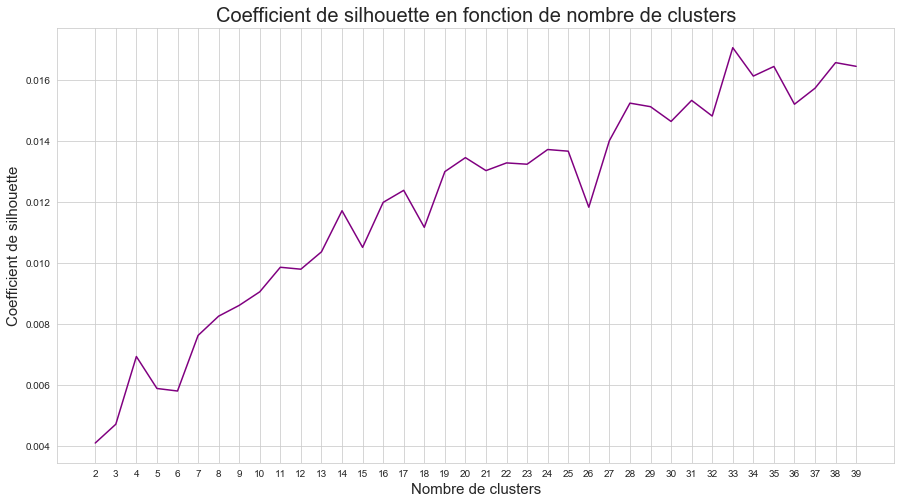

In [72]:
def choose_num_k(data, num_max):
    """Function which helps to choose an optimal number of clusters for MiniBatchKmeans algorithme.abs
    
    Inputs:
    - data : an array of data to be clusteres
    - num_max : a maximal number of clusters
    
    Output:
    - a plot of silhouette coefficient depending on number of clusters 
    
    """
    silhouette = []
    k = list(range(2, num_max))
    
    # Fit the model
    for i in k:
        kmeans = MiniBatchKMeans(n_clusters=i, init_size=1024, batch_size=2048, random_state=20)
        y_pred = kmeans.fit_predict(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette.append(score)
        
    # Plot the silhouette coefficient        
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Nombre de clusters', fontsize=15)
    ax.set_xticks(k)
    ax.set_xticklabels(k)
    ax.set_ylabel('Coefficient de silhouette', fontsize=15)
    ax.set_title('Coefficient de silhouette en fonction de nombre de clusters', fontsize=20)


    plt.plot(k, silhouette, color="purple")
    

choose_num_k(X_train_tfidf, 40)    

Nous allons choisir 14 clusters.

#### Créer le modèle

In [73]:
def predict_MiniBatchKMeans(data,k):
    """Function which returns a vector of k predicted clusters using MiniBatchKMeans algorithm.
    
    INPUTS:
    - data : en array of data to be clustered
    - k : number of clusters
    
    OUTPUT:
    - a vector of k predicted clusters    
    """
    # Fit the model
    kmeans = MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20)
    
    # Predict clusters
    y_pred = kmeans.fit_predict(data)
    return y_pred
    
clusters = predict_MiniBatchKMeans(X_train_tfidf,14)   

#### Visualisation de clusters

In [74]:
def plot_clusters(X, clusters, k, model='PCA'):
    """Function to plot a 2D scatter plot of clusters. The dimensionnality reduction is done either by PCA
    or by t-SNE
    
    INPUTS:
    - X : array of data 
    - clusters : a vector of clusters (max = 14)
    - k : number of clusters
    - model : 'PCA' (default) or 'TSNE'
    
    OUTPUT:
    - a scatterplot of k clusters   
     
    
    """
    
    # Define the color's vector
    colors = ['salmon', 'khaki', 'darkviolet', 'black', 'blue', 'green', 'indigo', 
              'yellow', 'red', 'violet', 'c', 'darkslategrey', 'orange', 'olive']
    
    # Define the title
    mean_title = str('Title k-means clusters in ' + model + ' representation')
    
    # Format the cluster's vector
    y_pred_df = DataFrame(clusters)
    y_pred_df.rename({0: 'Cluster'}, axis=1, inplace=True)
    
    # Define the model
    if model=='PCA':
        mod = PCA(n_components=2)
    else:
        mod = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
        
    # Fit the model
    principalComponents = mod.fit_transform(X)
    
    # Create the DataFrame of principal components + clusters
    principalDf = pd.DataFrame(data=principalComponents, columns=[
                           'principal component 1', 'principal component 2'])
    principalDf = principalDf.merge(y_pred_df, left_index=True, right_index=True)
    
    # Plot the figure    
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Principal Component 1', fontsize=10)
    ax.set_ylabel('Principal Component 2', fontsize=10)
    ax.set_title(mean_title, fontsize=12)

    targets = list(range(k))
    for target, color in zip(targets, colors[:k]):
        indicesToKeep = principalDf['Cluster'] == target
        ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1'],
               principalDf.loc[indicesToKeep, 'principal component 2'], c=color, s=50, alpha=0.5)
    ax.legend(targets)
    ax.grid()
    

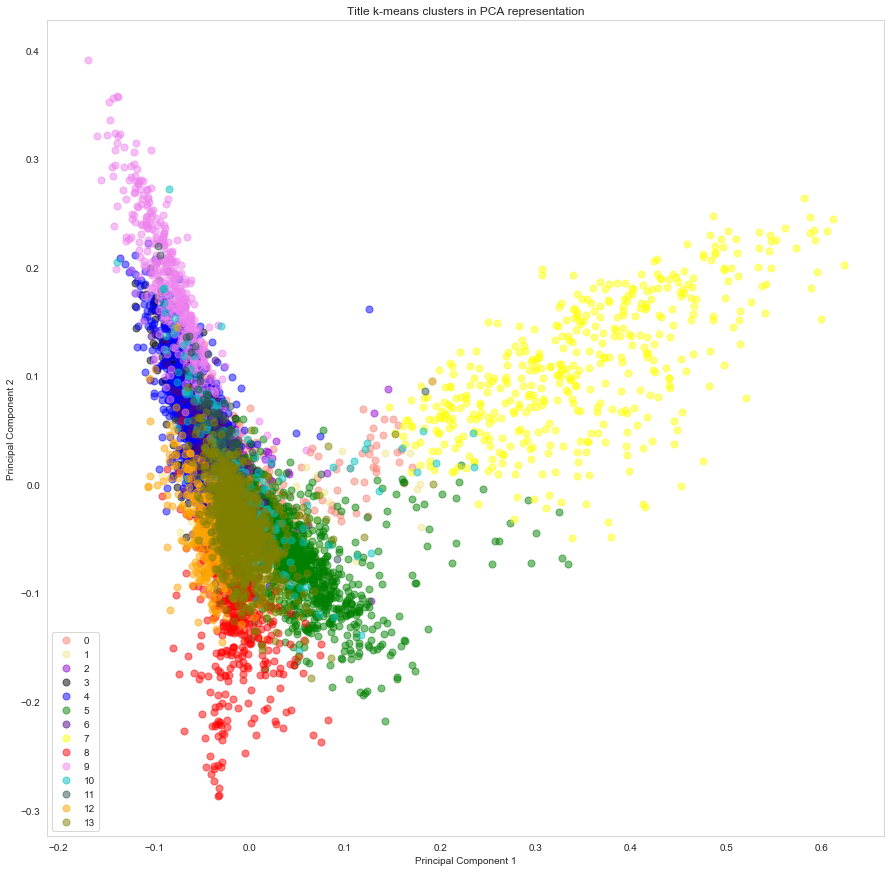

In [75]:
plot_clusters(X_train_tfidf, clusters, 14)

t-SNE

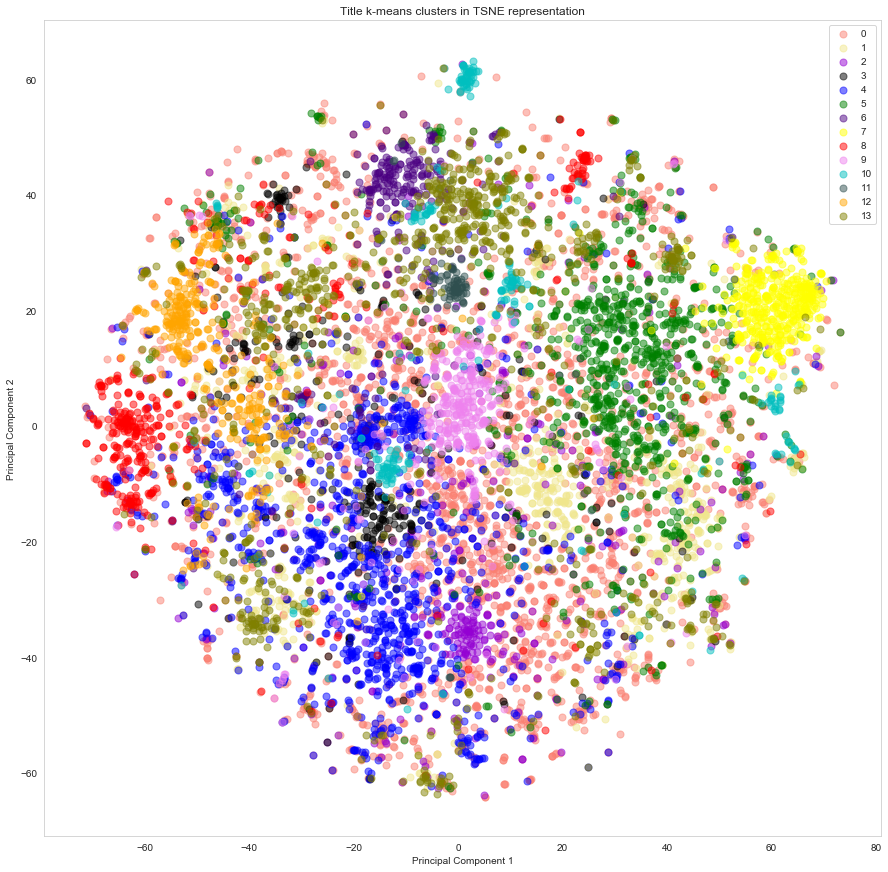

In [76]:
plot_clusters(X_train_tfidf, clusters, 14, model='TSNE')

#### Description de clusters

In [79]:
def print_top_words(k, vocabulary, distances, clusters):
    """Funtion which returns 10 top words for each cluster.abs
    
    INPUTS :
    - k : number of clusters
    - vocabulary : a list of vocabulary
    - distances : a list of distances
    - clusters : a vector of clusters
    
    OUTPUT :
    - print a list of 10 most frequent words for each cluster
    
    """
    
    top_words = DataFrame(zip(vocabulary, distances, clusters), 
                      columns=['word', 'dist', 'cluster'])
    for i in range(k):
        temp = top_words[top_words['cluster']==i]
        temp = temp.sort_values(['dist'], ascending=False)[:10]
        print("Cluster" + str(i) + ": ") 
        print(list(temp['word']))
        print('\n')
        
print_top_words(14, X_train_vocab_tfidf, X_train_dist_tfidf, clusters)

Cluster0: 
['get', 'code', 'difference', 'class', 'python', 'java', 'user', 'c', 'error', 'image']


Cluster1: 
['type', 'array', 'key', 'web', 'content', 'r', 'mysql', 'item', 'output', 'start']


Cluster2: 
['application', 'com', 'module', 'build', 'edit', 'linux', 'always', 'count', 'byte', 'py']


Cluster3: 
['name', 'time', 'table', 'version', 'size', 'password', 'specific', 'github', 'style', 'activity']


Cluster4: 
['like', 'function', 'android', 'app', 'set', 'div', 'j', 'net', 'case', 'sql']


Cluster5: 
['file', 'object', 'return', 'project', 'script', 'variable', 'int', 'public', 'library', 'request']


Cluster6: 
['list', 'column', 'result', 'write', 'install', 'folder', 'g', 'ruby', 'given', 'space']


Cluster7: 
['event', 'update', 'f', 'tag', 'programming', 'width', 'screen', 'visual', 'action', 'us']


Cluster8: 
['server', 'command', 'someone', 'best-way', 'location', 'false', 'expression', 'mvc', 'empty', 'node-j']


Cluster9: 
['string', 'git', 'mean', 'input', 'lan

### Feature = titre

#### Choisir le nombre de clusters

Dans un premier temps, nous allons étudier le nombre de clusters optimal à l'aide de **coefficient de silhouette**.

In [ ]:
choose_num_k(X_train_title_tfidf, 40) 

Le coefficient de silhouette augmente avec le nombre de clusters. Il faudra faire un compromis entre le nombre de cluster raisonnable et la qualité de clusters. Nous allons choisir 14 clusters qui avec le coefficient de silhouette de 0.017 environ.

#### Créer le modèle

Nous allons choisir 14 clusters :

In [ ]:
clusters = predict_MiniBatchKMeans(X_train_title_tfidf,14)   

#### Visualisation de clusters

Tout d'abord, nous allons visualiser les données avec l'ACP :

In [ ]:
plot_clusters(X_train_title_tfidf, clusters, 14)

In [ ]:
plot_clusters(X_train_title_tfidf, clusters, 14, model='TSNE')

#### Description de clusters

In [ ]:
print_top_words(14, X_train_title_vocab_tfidf, X_train_title_dist_tfidf, y_pred)

### Feature = tags

#### Choisir le nombre de clusters

Dans un premier temps, nous allons étudier le nombre de clusters optimal à l'aide de **coefficient de silhouette**.

In [ ]:
choose_num_k(y_train_tfidf, 40) 

#### Créer le modèle

Nous allons choisir 12 clusters :

In [ ]:
clusters = predict_MiniBatchKMeans(y_train_tfidf,12)   

#### Visualisation de clusters

Tout d'abord, nous allons visualiser les données avec l'ACP :

In [ ]:
plot_clusters(y_train_tfidf, clusters, 12)

Le second graphique sera fait avec t-SNE:

In [ ]:
plot_clusters(y_train_tfidf, clusters, 12, model='TSNE')

#### Description de clusters

In [ ]:
print_top_words(12, y_train_vocab_tfidf, y_train_dist_tfidf, y_pred)

# Modélisation supervisée

## KNN + word2vect

In [101]:
from gensim.models import Word2Vec

In [102]:
model = Word2Vec.load("300features_10minwords_10context")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\utils.py:491: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  setattr(self, attrib, None)


In [103]:
X_train_title_w2v[:10]

array([[ 0.30054867, -1.4640574 , -1.2133819 , ...,  0.22301418,
         0.14499556,  0.13245034],
       [-0.08782956, -0.8410531 , -0.02309181, ..., -0.08632898,
         0.02671246,  0.09479914],
       [ 0.128168  , -0.98216194, -0.63779575, ...,  0.19645655,
         0.9787061 , -0.41814962],
       ...,
       [-0.09813353,  0.33052382,  0.03520536, ..., -0.03743832,
        -0.00344976, -0.2098835 ],
       [-0.10450368, -1.2387942 , -0.045147  , ...,  0.13419873,
         0.02989972,  0.24243808],
       [ 0.11300585, -0.40825477,  0.11280496, ..., -0.40281233,
         0.08666296, -0.06616844]], dtype=float32)

In [107]:
X_train_title_w2v.shape

(9726, 300)

In [106]:
X_train_post_w2v.shape

(9843, 300)

In [109]:
y_train_bow.shape

(9843, 4998)

In [105]:
X_train_post_w2v[:10]

array([[ 0.25211206, -0.99172276, -0.9873311 , ...,  0.25392833,
         0.02525808,  0.08697739],
       [ 0.15314457, -0.85524356, -0.06960209, ...,  0.06481431,
         0.2699113 ,  0.09317841],
       [ 0.13769308, -0.23598024, -0.07117636, ...,  0.17997412,
         0.4997458 , -0.25789046],
       ...,
       [-0.07903808, -0.56833184, -0.27586994, ...,  0.06835229,
         0.05875414,  0.1530387 ],
       [-0.09988103, -0.95481277,  0.02846703, ..., -0.02180135,
         0.09724246, -0.05001929],
       [-0.21263295, -0.743743  , -0.5176179 , ..., -0.0377328 ,
        -0.17797273,  0.27275893]], dtype=float32)

In [110]:
X_train_tfidf.shape

(9843, 5000)

In [111]:
y_train_tfidf.shape

(9843, 4998)

In [114]:
from sklearn.neighbors import KNeighborsClassifier

In [115]:
knn = KNeighborsClassifier()

In [116]:
knn.fit(X_train_post_w2v, y_train_bow100)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [118]:
predicted_tags_knn = knn.fit(X_train_post_w2v, y_train_bow100).predict(X_train_post_w2v)